## Perspectives on Computational Research -- HW02
## Author: Sanittawan Tan

In [1]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
from keras import losses
from keras import metrics

Using TensorFlow backend.


In [3]:
# check NAs (do this for 3 files)
types_dict = {'BillID': 'str', 'BillNum': 'str', 'Title': 'str', 'Major': 'str'}
df = pd.read_csv('./data/congress_test.csv', dtype=types_dict, encoding="ISO-8859-1")
for col in types_dict.keys():
    print(sum(df[col].isna()))

0
0
0
0


### Process and tokenize the data

In [4]:
def process_file(filepath):
    types_dict = {'BillID': 'str', 'BillNum': 'str', 'Title': 'str', 'Major': 'Int64'}
    df = pd.read_csv(filepath, dtype=types_dict, encoding="ISO-8859-1")
    text = df['Title'].tolist()
    label = df['Major'].tolist()
    return text, label

In [5]:
train_text, train_label = process_file('./data/congress_train.csv') 
val_text, val_label = process_file('./data/congress_val.csv')
test_text, test_label = process_file('./data/congress_test.csv')

In [6]:
max_len = 100
max_words = 10000

In [7]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
train_sequences = tokenizer.texts_to_sequences(train_text)
word_index = tokenizer.word_index
train_text = pad_sequences(train_sequences, maxlen=max_len)

In [9]:
val_sequences = tokenizer.texts_to_sequences(val_text)
val_text = pad_sequences(val_sequences, maxlen=max_len)

In [10]:
test_sequences = tokenizer.texts_to_sequences(test_text)
test_text = pad_sequences(test_sequences, maxlen=max_len)

In [11]:
# one hot encoding the labels
train_label = to_categorical(train_label)
val_label = to_categorical(val_label)
test_label = to_categorical(test_label)

### Prepare GloVe word-embeddings

In [12]:
# parsing the Glove word-embeddings (from the book)
glove_dir = '/home/ubuntu/hw02-1'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [13]:
# preparing Glove word-embeddings matrix (from the book)
max_words = 10000
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 1) Estimate a basic feed-forward network (without pre-trained word embeddings)

In [14]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten, Dense

In [23]:
# how to select dimension ? 8?
ff_no_glove = Sequential()
ff_no_glove.add(Embedding(10000, 64, input_length=max_len))
ff_no_glove.add(Flatten())
ff_no_glove.add(Dense(24, activation='softmax'))
ff_no_glove.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])
ff_no_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                153624    
Total params: 793,624
Trainable params: 793,624
Non-trainable params: 0
_________________________________________________________________


In [24]:
ff_no_glove_history = ff_no_glove.fit(train_text, train_label,
                                      epochs=50,
                                      batch_size=512,
                                      validation_data=(val_text, val_label))

Train on 278612 samples, validate on 69649 samples
Epoch 1/50
278612/278612 [==============================] - 4s 14us/step - loss: 1.5043 - acc: 0.5961 - val_loss: 0.7978 - val_acc: 0.7919
Epoch 2/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.6704 - acc: 0.8178 - val_loss: 0.6389 - val_acc: 0.8287
Epoch 3/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.5564 - acc: 0.8467 - val_loss: 0.5960 - val_acc: 0.8407
Epoch 4/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.4985 - acc: 0.8616 - val_loss: 0.5749 - val_acc: 0.8460
Epoch 5/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.4570 - acc: 0.8730 - val_loss: 0.5664 - val_acc: 0.8501
Epoch 6/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.4241 - acc: 0.8816 - val_loss: 0.5594 - val_acc: 0.8516
Epoch 7/50
278612/278612 [==============================] - 3s 12us/step - loss: 0.3962 - acc: 0.8895 - val_loss: 0

In [28]:
ff_no_glove_history_dict = ff_no_glove_history.history
ff_no_glove_val_acc = ff_no_glove_history_dict['val_acc'] 
ff_no_golve_val_loss = ff_no_glove_history_dict['val_loss']

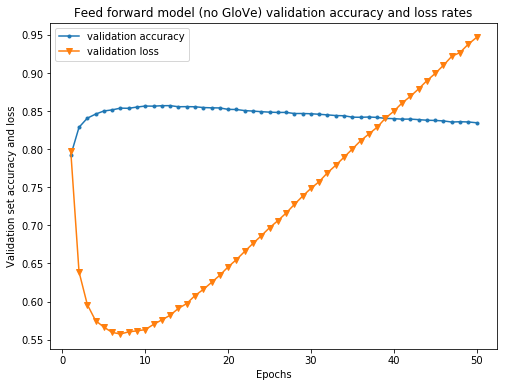

In [42]:
epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(epochs, ff_no_glove_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, ff_no_golve_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('Feed forward model (no GloVe) validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 2) Estimate a basic feed-forward network (with GloVe word embeddings)

In [36]:
ff_w_glove = Sequential()
ff_w_glove.add(Embedding(10000, embedding_dim, input_length=max_len))
ff_w_glove.add(Flatten())
ff_w_glove.add(Dense(24, activation='softmax'))
ff_w_glove.summary()
ff_w_glove.layers[0].set_weights([embedding_matrix])
ff_w_glove.layers[0].trainable = False

ff_w_glove.compile(optimizer='rmsprop',
                   loss='categorical_crossentropy',
                   metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                240024    
Total params: 1,240,024
Trainable params: 1,240,024
Non-trainable params: 0
_________________________________________________________________


In [37]:
ff_w_glove.layers[0].set_weights([embedding_matrix])
ff_w_glove.layers[0].trainable = False

In [38]:
ff_w_glove_history = ff_w_glove.fit(train_text, train_label,
                                    epochs=50,
                                    batch_size=512,
                                    validation_data=(val_text, val_label))

Train on 278612 samples, validate on 69649 samples
Epoch 1/50
278612/278612 [==============================] - 3s 12us/step - loss: 1.4329 - acc: 0.5935 - val_loss: 1.1881 - val_acc: 0.6580
Epoch 2/50
278612/278612 [==============================] - 3s 11us/step - loss: 1.0556 - acc: 0.6976 - val_loss: 1.0853 - val_acc: 0.6919
Epoch 3/50
278612/278612 [==============================] - 3s 11us/step - loss: 0.9677 - acc: 0.7227 - val_loss: 1.0422 - val_acc: 0.7049
Epoch 4/50
278612/278612 [==============================] - 3s 10us/step - loss: 0.9194 - acc: 0.7361 - val_loss: 1.0418 - val_acc: 0.7080
Epoch 5/50
278612/278612 [==============================] - 3s 10us/step - loss: 0.8876 - acc: 0.7461 - val_loss: 1.0431 - val_acc: 0.7037
Epoch 6/50
278612/278612 [==============================] - 3s 11us/step - loss: 0.8645 - acc: 0.7520 - val_loss: 1.0259 - val_acc: 0.7155
Epoch 7/50
278612/278612 [==============================] - 3s 10us/step - loss: 0.8460 - acc: 0.7567 - val_loss: 1

In [39]:
ff_w_glove_history_dict = ff_w_glove_history.history
ff_w_glove_val_acc = ff_w_glove_history_dict['val_acc'] 
ff_w_golve_val_loss = ff_w_glove_history_dict['val_loss']

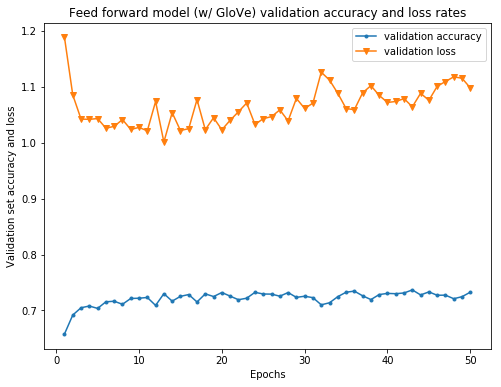

In [41]:
epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(epochs, ff_w_glove_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, ff_w_golve_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('Feed forward model (w/ GloVe) validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 3) Recurrent Neural Network (RNN) with a `layer_simple_rnn`

In [43]:
from keras.layers import SimpleRNN

In [49]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(10000, 32, input_length=max_len))
simple_rnn.add(SimpleRNN(32))
simple_rnn.add(Dense(24, activation='softmax'))
simple_rnn.summary()

simple_rnn.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 24)                792       
Total params: 322,872
Trainable params: 322,872
Non-trainable params: 0
_________________________________________________________________


In [50]:
simple_rnn_history = simple_rnn.fit(train_text, train_label,
                                      epochs=50,
                                      batch_size=512,
                                      validation_data=(val_text, val_label))

Train on 278612 samples, validate on 69649 samples
Epoch 1/50
278612/278612 [==============================] - 45s 160us/step - loss: 2.3081 - acc: 0.3158 - val_loss: 1.7306 - val_acc: 0.4981
Epoch 2/50
278612/278612 [==============================] - 44s 157us/step - loss: 1.4008 - acc: 0.6113 - val_loss: 1.3076 - val_acc: 0.6421
Epoch 3/50
278612/278612 [==============================] - 44s 157us/step - loss: 1.0772 - acc: 0.7162 - val_loss: 1.0788 - val_acc: 0.7187
Epoch 4/50
278612/278612 [==============================] - 44s 157us/step - loss: 0.9240 - acc: 0.7603 - val_loss: 0.9728 - val_acc: 0.7453
Epoch 5/50
278612/278612 [==============================] - 44s 157us/step - loss: 0.8306 - acc: 0.7860 - val_loss: 0.9724 - val_acc: 0.7454
Epoch 6/50
278612/278612 [==============================] - 44s 157us/step - loss: 0.7561 - acc: 0.8060 - val_loss: 0.8358 - val_acc: 0.7870
Epoch 7/50
278612/278612 [==============================] - 44s 157us/step - loss: 0.7056 - acc: 0.8194

In [51]:
simple_rnn_history_dict = simple_rnn_history.history
simple_rnn_val_acc = simple_rnn_history_dict['val_acc'] 
simple_rnn_val_loss = simple_rnn_history_dict['val_loss']

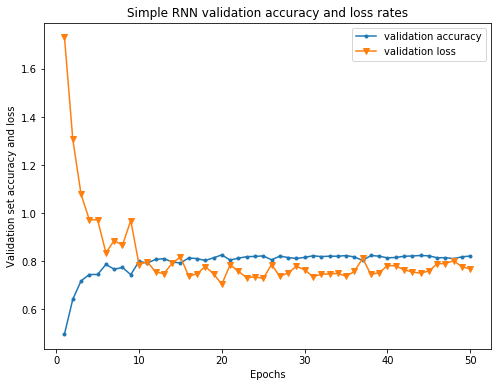

In [52]:
epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(epochs, simple_rnn_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, simple_rnn_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('Simple RNN validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 4) Recurrent Neural Network (RNN) with an LSTM layer (*20 epochs*)

In [53]:
from keras.layers import LSTM

In [54]:
rnn_lstm = Sequential()
rnn_lstm.add(Embedding(10000, 32, input_length=max_len))
rnn_lstm.add(LSTM(32))
rnn_lstm.add(Dense(24, activation='softmax'))
rnn_lstm.summary()

rnn_lstm.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                792       
Total params: 329,112
Trainable params: 329,112
Non-trainable params: 0
_________________________________________________________________


In [56]:
# decrease number of epochs to reduce training time
rnn_lstm_history = rnn_lstm.fit(train_text, train_label,
                                epochs=20,
                                batch_size=512,
                                validation_data=(val_text, val_label))

Train on 278612 samples, validate on 69649 samples
Epoch 1/20
278612/278612 [==============================] - 104s 373us/step - loss: 1.0955 - acc: 0.7189 - val_loss: 0.8969 - val_acc: 0.7737
Epoch 2/20
278612/278612 [==============================] - 104s 372us/step - loss: 0.7808 - acc: 0.8025 - val_loss: 0.7876 - val_acc: 0.7960
Epoch 3/20
278612/278612 [==============================] - 104s 372us/step - loss: 0.6701 - acc: 0.8261 - val_loss: 0.6878 - val_acc: 0.8216
Epoch 4/20
278612/278612 [==============================] - 104s 372us/step - loss: 0.6083 - acc: 0.8390 - val_loss: 0.6635 - val_acc: 0.8231
Epoch 5/20
278612/278612 [==============================] - 103s 371us/step - loss: 0.5665 - acc: 0.8475 - val_loss: 0.6233 - val_acc: 0.8320
Epoch 6/20
278612/278612 [==============================] - 104s 372us/step - loss: 0.5352 - acc: 0.8546 - val_loss: 0.5997 - val_acc: 0.8378
Epoch 7/20
278612/278612 [==============================] - 104s 372us/step - loss: 0.5104 - acc:

In [57]:
rnn_lstm_history_dict = rnn_lstm_history.history
rnn_lstm_val_acc = rnn_lstm_history_dict['val_acc'] 
rnn_lstm_val_loss = rnn_lstm_history_dict['val_loss']

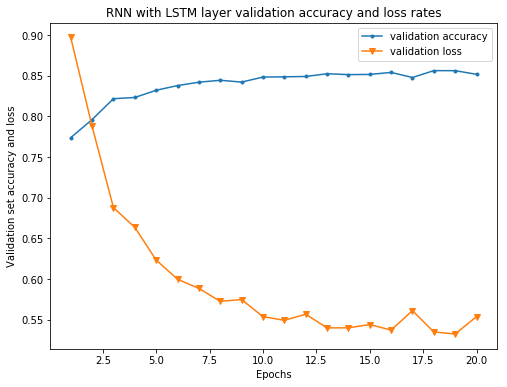

In [58]:
epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(epochs, rnn_lstm_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, rnn_lstm_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('RNN with LSTM layer validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 5) Recurrent Neural Network (RNN) with a GRU layer (*20 epochs*)

In [59]:
from keras.layers import GRU

In [60]:
rnn_gru = Sequential()
rnn_gru.add(Embedding(10000, 32, input_length=max_len))
rnn_gru.add(GRU(32))
rnn_gru.add(Dense(24, activation='softmax'))
rnn_gru.summary()

rnn_gru.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_13 (Dense)             (None, 24)                792       
Total params: 327,032
Trainable params: 327,032
Non-trainable params: 0
_________________________________________________________________


In [61]:
rnn_gru_history = rnn_gru.fit(train_text, train_label,
                            epochs=20,
                            batch_size=512,
                            validation_data=(val_text, val_label))

Train on 278612 samples, validate on 69649 samples
Epoch 1/20
278612/278612 [==============================] - 86s 307us/step - loss: 2.3866 - acc: 0.2753 - val_loss: 1.8848 - val_acc: 0.4700
Epoch 2/20
121344/278612 [============>.................] - ETA: 43s - loss: 1.6568 - acc: 0.5360

KeyboardInterrupt: 

In [ ]:
rnn_gru_history_dict = rnn_gru_history.history
rnn_gru_val_acc = rnn_gru_history_dict['val_acc'] 
rnn_gru_val_loss = rnn_gru_history_dict['val_loss']

In [ ]:
epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(epochs, rnn_gru_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, rnn_gru_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('RNN with GRU layer validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 6) Naive approach (no word embeddings) intended as baseline

In [ ]:
naive = Sequential()
naive.add(Dense(64, activate='relu'))
naive.add(Dense(64, activate='relu'))
naive.add(Dense(64, activate='relu'))
naive.add(Dense(24, activate='softmax'))
naive.summary()

naive.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
naive_history = naive.fit(train_text, train_label,
                          epochs=50,
                          batch_size=512,
                          validation_data=(val_text, val_label))

In [ ]:
naive_history_dict = naive_history.history
naive_val_acc = naive_history_dict['val_acc'] 
naive_val_loss = naive_history_dict['val_loss']

In [ ]:
epochs = np.arange(1, 51)
plt.figure(figsize=(8, 6))
plt.plot(epochs, naive_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, naive_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('Naive approach validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 7) RNN with GRU layer and dropout regularization

In [ ]:
gru_dropout = Sequential()
gru_dropout.add(Embedding(10000, 32, input_length=max_len))
gru_dropout.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
gru_dropout.add(Dense(24, activation='softmax'))
gru_dropout.summary()

gru_dropout.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [ ]:
gru_dropout_history = gru_dropout.fit(train_text, train_label,
                              epochs=20,
                              batch_size=512,
                              validation_data=(val_text, val_label))

In [ ]:
gru_dropout_history_dict = gru_dropout_history.history
gru_dropout_val_acc = gru_dropout_history_dict['val_acc'] 
gru_dropout_val_loss = gru_dropout_history_dict['val_loss']

In [ ]:
epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(epochs, gru_dropout_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, gru_dropout_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('RNN with GRU layer and dropout validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 8) RNN with stacked LSTM layers

In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(Embedding(10000, 32, input_length=max_len))
stacked_lstm.add(LSTM(32, return_sequences=True))
stacked_lstm.add(LSTM(32, return_sequences=True))
stacked_lstm.add(LSTM(32))
stacked_lstm.add(Dense(24, activation='softmax'))
stacked_lstm.summary()

stacked_lstm.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [ ]:
# decrease number of epochs to reduce training time
stacked_lstm_history = stacked_lstm.fit(train_text, train_label,
                                        epochs=20,
                                        batch_size=512,
                                        validation_data=(val_text, val_label))

In [ ]:
stacked_lstm_history_dict = stacked_lstm_history.history
stacked_lstm_val_acc = stacked_lstm_history_dict['val_acc'] 
stacked_lstm_val_loss = stacked_lstm_history_dict['val_loss']

In [ ]:
epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(epochs, stacked_lstm_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, stacked_lstm_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('RNN with stacked LSTM layers validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 9)

In [ ]:
rnn_gru = Sequential()
rnn_gru.add(Embedding(10000, 32, input_length=max_len))
rnn_gru.add(GRU(32))
rnn_gru.add(Dense(24, activation='softmax'))
rnn_gru.summary()

rnn_gru.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [ ]:
rnn_gru_history = rnn_gru.fit(train_text, train_label,
                            epochs=20,
                            batch_size=512,
                            validation_data=(val_text, val_label))

In [ ]:
rnn_gru_history_dict = rnn_gru_history.history
rnn_gru_val_acc = rnn_gru_history_dict['val_acc'] 
rnn_gru_val_loss = rnn_gru_history_dict['val_loss']

In [ ]:
epochs = np.arange(1, 21)
plt.figure(figsize=(8, 6))
plt.plot(epochs, rnn_gru_val_acc, label='validation accuracy', marker='.')
plt.plot(epochs, rnn_gru_val_loss, label='validation loss', marker='v')
plt.ylabel('Validation set accuracy and loss')
plt.xlabel('Epochs')
plt.title('RNN with GRU layer validation accuracy and loss rates')
plt.legend(loc='best')
plt.show()

### 10)